Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Benchmarking Message Passing on the IPU

One of the key features of GNNs is message passing where a node's features are passed to its neighbours through some operations. Message passing essentially consists in two operations, namely gathering the node embeddings onto their outbound edges and scattering the result onto the nodes that these edges connect to. There can be a number of additional operations between the gather and scatter, depending on the architecture of the model you are interested in, and therefore it is useful to consider the gather and scatter operations as distinct steps in message passing.

![Message Passing](./static/gather_scatter.jpg "Message Passing")

In this notebook we will take a look at the performance of the gather and scatter operations on Graphcore hardware in order to understand the performance advantage the IPU offers for these operations. Accelerating these fundamental operations with the IPU also directly translates into performance advantages in message passing and GNNs as a whole.

Herein, we will:
 * Understand how we construct a harness to run benchmarks of particular operations on the IPU,
 * Run a sweep of scatter and gather operations on the IPU,
 * Take a look at the results of a larger sweep.

Let's get started!

### Running on Paperspace

The Paperspace environment lets you run this notebook with minimal effort. To improve your experience we preload datasets and pre-install packages, this can take a few minutes. If you experience errors immediately after starting a session, please try restarting the kernel before contacting support. If a problem persists or you want to give us feedback on the content of this notebook, please reach out to us through our community of developers using our [slack channel](https://www.graphcore.ai/join-community) or raise a [GitHub issue](https://github.com/graphcore/examples).

To set up the requirements for running the session, simply run the following line:

In [1]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


And for compatibility with the Paperspace environment variables we will do the following:

In [2]:
import os
import poptorch

poptorch.setLogLevel("ERR")
executable_cache_dir = (
    os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/") + "/pyg-benchmark"
)

Now we are ready to benchmark gather and scatter operations on the IPU.

## Setting up the benchmarks

In this section we will discuss how we will run the benchmarks in this notebook on the IPU.

First we create a simple module which runs a scatter operation. 

This module does the following:
 * Creates random input `feature vectors` and `edge indices`,
 * Performs a `torch scatter` scatter operation with the requested reduce type, using these inputs, returning the output.
 * Registers `buffers` for the inputs and outputs, which reduces the host-IPU communication.

See the full implementation in `benchmark_util.py` for all the details.

In [3]:
from benchmark_util import ScatterOp

op = ScatterOp(num_inputs=4,
               num_features=4,
               num_outputs=16,
               reduce="sum")

print(f"{op.input = }")
print(f"{op.index = }")

op.input = tensor([[-0.1243,  0.3325,  0.9548, -0.6343],
        [ 0.6766, -0.0419, -2.3790, -0.9953],
        [ 1.2449,  0.3810, -0.0167, -1.3510],
        [ 0.3420,  0.8701, -1.3573, -1.1568]])
op.index = tensor([12,  5,  0, 15])


In the context of GNNs you can think of the scatter operation as sending the node features (which have been collected from the source nodes using the gather operation) to the target nodes of each edge, and using the reduce operation where the same target node receives multiple features. This way, the input size corresponds to the number of outbound edges times the feature vector size for each node in the graph, while the size of the indices corresponds to the number of neighbours for each node (with the actual values up to the total number of nodes).

Now we wrap this module in a PopTorch `for_loop`. This creates a loop on the IPU that runs the benchmarked operation for a particular number of counts. We have put this in a separate module which you can see the details of in `benchmark_util.py`.

In [4]:
from benchmark_util import Benchmark

model = Benchmark(num_repeats=10, operator=op)

This model is almost ready to run on IPUs but first we will create some PopTorch options we will use with the model. The most interesting ones are:
 * Turning on synthetic data - this disables host I/O to ensure we are measuring the performance of the operation only. See the [PopTorch documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/reference.html?highlight=enablesyntheticdata#poptorch.Options.enableSyntheticData) for more details. Feel free to try turning this option off and see how it changes the performance results.
 * Logging cycle count - this allows us to see the cycles of the operation. See the [PopTorch documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/reference.html?highlight=cycle%20count#poptorch.Options.logCycleCount) for more details.

In [5]:
options = poptorch.Options()
options.enableSyntheticData(True)
options.logCycleCount(True)
options.enableExecutableCaching(executable_cache_dir)
options.connectionType(poptorch.ConnectionType.OnDemand)

Options(replication_factor=1, input_group_size=1, input_cgt=<CommGroupType.Consecutive: 1>, broadcast_buffers=True, device_iterations=1, log_dir='.', max_repeat_logs=4, auto_round_num_ipus=False, anchored_tensors={}, output_mode=4, output_return_period=1, connection_type=1, sync_pattern=0, available_memory_proportion={}, Distributed=_DistributedOptions(num_distributed_processes=1, distributed_process_id=0, ipuof_configs={}, _gcd_mappings={}, _warnings={}, _warnings_disabled=set(), _is_frozen=False), Jit=_JitOptions(, _warnings={}, _warnings_disabled=set(), _is_frozen=False), Precision=_PrecisionOptions(, _popart_options=_PopartOptions(instrumentWithHardwareCycleCounter=True, rearrangeAnchorsOnHost=False, syntheticDataMode=2, cachePath='/tmp/exe_cache//pyg-benchmark', enableEngineCaching=True), _warnings={}, _warnings_disabled=set(), _is_frozen=False), TensorLocations=_TensorLocationOptions(, _warnings={}, _warnings_disabled=set(), _is_frozen=False), Training=_TrainingOptions(gradient_a

We are now ready to convert our model into a PopTorch model and compile it, making it ready to run on IPUs:

In [6]:
pop_model = poptorch.inferenceModel(model, options=options)
pop_model.compile()

Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


We now create an object to log the performance of our model. This tracks the number of IPU cycles for each call and will give us an indication of bandwidth of the underlying operation. For full details see the implementation in `benchmark_util.py`.

In [7]:
from benchmark_util import PerfMetrics

metrics = PerfMetrics(pop_model, num_repeats=5)

Now we are ready to run a benchmark. We run the above components in a loop and collect the results, following a few warm up iterations to reduce measurement noise.

In [8]:
def benchmark(pop_model, num_repeats):
    num_warmup_rounds = 5

    for _ in range(num_warmup_rounds):
        _ = pop_model()

    metrics = PerfMetrics(pop_model, num_repeats=num_repeats)
    benchmark_results = []

    for _ in range(num_repeats):
        _ = pop_model()
        values = metrics.update(pop_model.cycleCount())
        benchmark_results.append(values)
    
    return benchmark_results

benchmark_results = benchmark(pop_model, num_repeats=5)

And we can view the results:

In [9]:
benchmark_results

[{'cycles': 3809.4,
  'time (μs)': 2.059135135135135,
  'effective bandwidth (GiB/s)': 0.11578578551422553},
 {'cycles': 3809.4,
  'time (μs)': 2.059135135135135,
  'effective bandwidth (GiB/s)': 0.11578578551422553},
 {'cycles': 3809.4,
  'time (μs)': 2.059135135135135,
  'effective bandwidth (GiB/s)': 0.11578578551422553},
 {'cycles': 3809.0,
  'time (μs)': 2.058918918918919,
  'effective bandwidth (GiB/s)': 0.11579794469359166},
 {'cycles': 3809.4,
  'time (μs)': 2.059135135135135,
  'effective bandwidth (GiB/s)': 0.11578578551422553}]

Note that the effective bandwidth reported is based on the number of cycles and the performance of a Graphcore Bow-M2000.

We now have some performance data for our scatter operation. This is the approach we will use for a range of sizes of operations for both scatter and gather operations, and demonstrate the high performance of Graphcore IPUs while running these operations leading to message passing acceleration in GNNs.

## Running a sweep of *scatter* operations

We have understood the approach we will take to run and benchmark the operations on IPU. Let's now run a sweep so we can demonstrate the IPUs high performance running scatter operations.

First let's decide the parameters for our sweep, in the interest of time we will only select a small sweep range. Feel free to extend the range to gather more performance data.

In [10]:
num_inputs = [2**e for e in range(5, 7)]
num_features = [2**e for e in range(5, 7)]
num_outputs = [2**e for e in range(10, 11)]

And create a Cartesian product of these parameters:

In [11]:
from itertools import product

sweep_params = product(num_inputs, num_features, num_outputs)

And run everything we have discussed above using the parameter sweep, logging the results to a pandas dataframe.

In [12]:
import pandas as pd

dfs = []
num_repeats = 128

for params in sweep_params:
    print(f"Benchmarking scatter with input size {params[0]}, "
          f"feature size {params[1]}, output size {params[2]}")

    op = ScatterOp(num_inputs=params[0],
                   num_features=params[1],
                   num_outputs=params[2],
                   reduce="sum")

    model = Benchmark(num_repeats=10, operator=op)
    pop_model = poptorch.inferenceModel(model, options=options)
    pop_model.compile()
    
    benchmark_results = benchmark(pop_model, num_repeats=10)
    
    df = pd.DataFrame(benchmark_results)
    p = {k: [v] * len(df) for k, v in zip(("num_inputs", "num_features", "num_outputs"), params)}
    df = pd.concat([pd.DataFrame(p), df], axis=1)
    dfs.append(df.mean().to_frame().T)

scatter_dfs = pd.concat(dfs)

Benchmarking scatter with input size 32, feature size 32, output size 1024


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


Benchmarking scatter with input size 32, feature size 64, output size 1024


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


Benchmarking scatter with input size 64, feature size 32, output size 1024


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


Benchmarking scatter with input size 64, feature size 64, output size 1024


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


Now lets visualise the results:

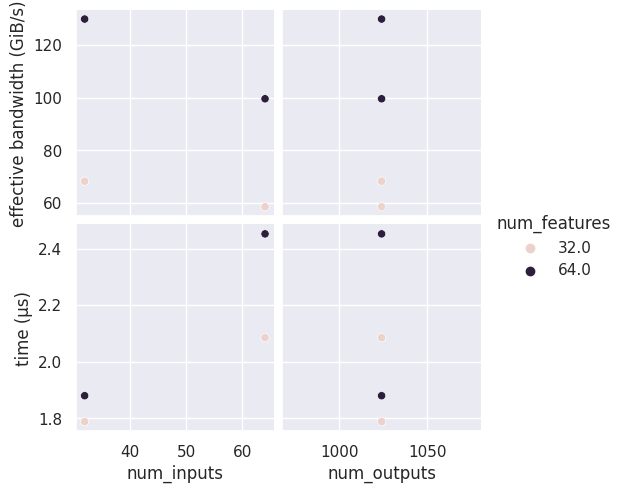

In [13]:
import seaborn as sns
sns.set_theme()

sns.pairplot(data=scatter_dfs, 
             x_vars=["num_inputs", "num_outputs"],
             y_vars=["effective bandwidth (GiB/s)", "time (μs)"],
             hue="num_features")

As we have only run a small sweep in the interest of time, here is a plot for a larger sweep:

![Scatter Benchmarks](./static/scatter_benchmarks.png "Scatter Benchmarks")

These results show how well the IPU performs across a wide range of hyperparameters for the scatter operation. We can observe that  observe a significant decrease in computation time as sparsity increases (i.e. smaller input and output sizes), situation in which GPUs provide negligible improvements ([Hosseini et al., 2022](https://arxiv.org/abs/2207.09955)).
So how much performance gain do we obtain with an IPU compared with an enterprise-grade GPU for example? The plots below show the performance gains for the size spectrum in which typical GNNs operate, as a speedup factor over the nVidia A100 (horizontal red line).

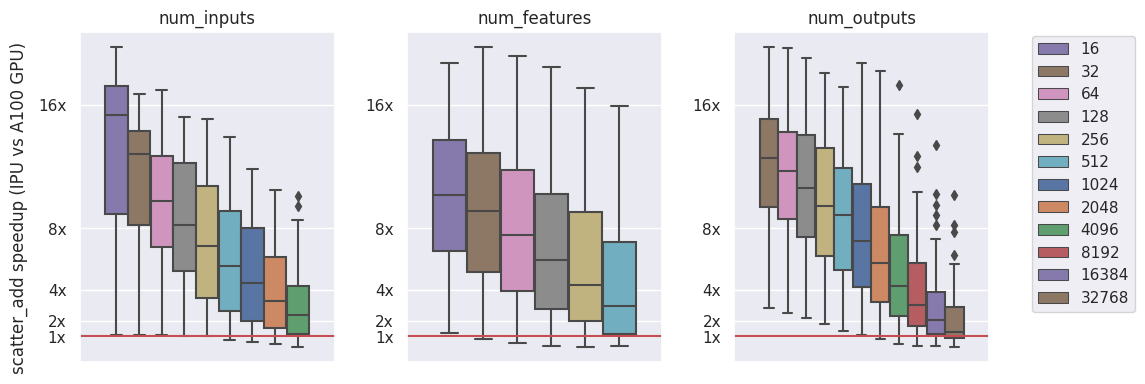

In [14]:
from benchmark_util import quick_benchmarks

quick_benchmarks("scatter_add")

The figures highlight the advantage offered by the Graphcore IPU compared to an nVidia A100. We observe statistically significant speedups towards the lower range of tensor sizes, while the GPU approaches the IPU's performance as sizes increase. It is important to note that in the case of sparse access (i.e. small scatter input sizes) the IPU achieves over 16 times the performance of a GPU under the same conditions.

Ok, we have seen excellent scatter results. Now we can do the same with gather to visualise IPU performance on that operation as well.

## Running a sweep of *gather* operations

First we create a module wrapping the `index_select` operation. This is very similar to the scatter module but feel free to take a look at the entire implementation in `benchmark_util.py` for more details.

In [15]:
from benchmark_util import GatherOp

op = GatherOp(num_inputs=4,
              num_features=4,
              num_outputs=16)

print(f"{op.input = }")
print(f"{op.index = }")

op.input = tensor([[ 0.4272, -1.4601, -0.8269, -0.3577],
        [-0.0129, -0.4382,  0.8560, -0.6564],
        [-0.8487, -0.7827,  0.5313, -0.0933],
        [-0.8356, -1.0434,  0.1898,  1.2574]])
op.index = tensor([3, 2, 0, 2, 3, 3, 2, 1, 1, 1, 2, 1, 0, 3, 0, 3])


In the context of GNNs you can think of the gather operation as collecting the node features onto the connecting edges. And so the input size can be thought of as the number of nodes, the feature size the size of the node embeddings and the output size the number of edges.

Then, in a similar way to scatter, we can benchmark a sweep of different sized inputs and outputs to this operation. Again we have used the reduced the sweep range in the interest of time.

In [16]:
import pandas as pd

sweep_params = product(num_inputs, num_features, num_outputs)
dfs = []
num_repeats = 128

for params in sweep_params:
    print(f"Benchmarking gather with input size {params[0]}, "
          f"feature size {params[1]}, output size {params[2]}")

    op = GatherOp(num_inputs=params[0],
                  num_features=params[1],
                  num_outputs=params[2])

    model = Benchmark(num_repeats=10, operator=op)
    pop_model = poptorch.inferenceModel(model, options=options)
    pop_model.compile()
    
    benchmark_results = benchmark(pop_model, num_repeats=10)
    
    df = pd.DataFrame(benchmark_results)
    p = {k: [v] * len(df) for k, v in zip(("num_inputs", "num_features", "num_outputs"), params)}
    df = pd.concat([pd.DataFrame(p), df], axis=1)
    dfs.append(df.mean().to_frame().T)

gather_dfs = pd.concat(dfs)

Benchmarking gather with input size 32, feature size 32, output size 1024


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


Benchmarking gather with input size 32, feature size 64, output size 1024


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


Benchmarking gather with input size 64, feature size 32, output size 1024


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


Benchmarking gather with input size 64, feature size 64, output size 1024


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00]


And again lets visualise the results:

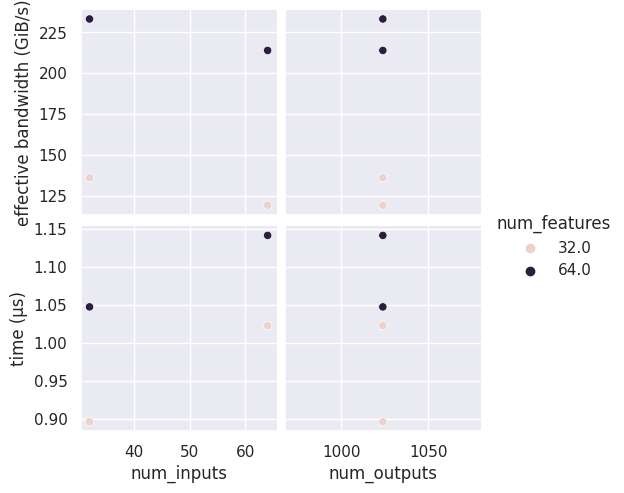

In [17]:
import seaborn as sns
sns.set_theme()

sns.pairplot(data=gather_dfs, 
             x_vars=["num_inputs", "num_outputs"],
             y_vars=["effective bandwidth (GiB/s)", "time (μs)"],
             hue="num_features")

Here is a larger sweep we have done previously in order to visualise the results:

![Gather Benchmarks](./static/gather_benchmarks.png "Gather Benchmarks")

Similarly to the scatter operation seen previously, these results show that sparse access is notably fast on the IPU with notably high performance in varying the number of inputs and outputs which GPUs do not tend to leverage ([Hosseini et al., 2022](https://arxiv.org/abs/2207.09955)).

Moreover, it is important to note here that these results are collected for one-dimensional gather, in order to report fair comparison results by maintaining a linear correspondance between memory accesses and the number of inputs and outputs, while multi-dimensional tensors could provide even more performance benefits compared to the GPU.

Let's look in closer detail on what this means in comparison to an enterprise-grade GPU:

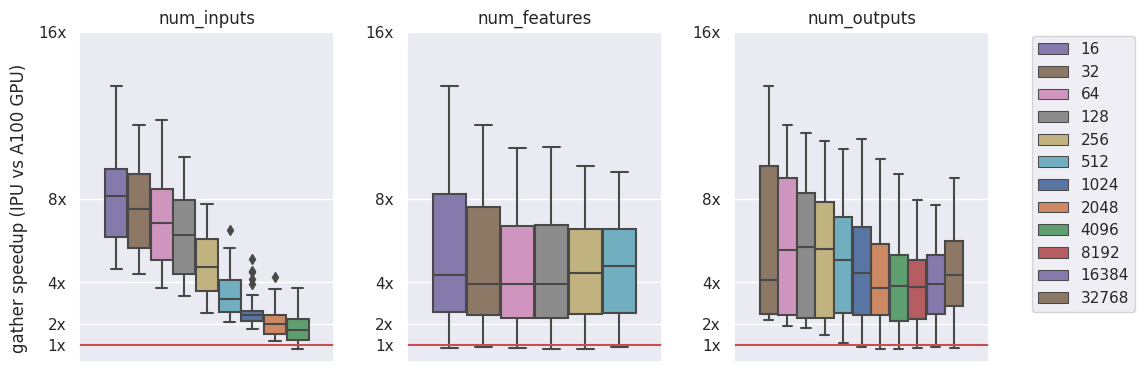

In [21]:
from benchmark_util import quick_benchmarks

quick_benchmarks("gather")

Et voilà! We again observe over 8x speedups compared to an A100 baseline (red line), with significantly higher performance across a wide range of hyperparameters, including the typical ranges within which GNN computations reside. This further confirms the advantages of the IPU's hardware characteristics which translate into more efficient compute in the realm of message passing neural networks.

## Conclusion

We have successfully benchmarked gather and scatter operations on the IPU and seen signficant advantages when compared with GPUs. We also discussed these operations' relevance in message passing and thus GNNs as a whole, which helps shine a light on the relevance of these benchmark results. Concretely we have:

* Understood how to set up an operation benchmark on the IPU,
* Run a sweep of gather and scatter benchmarks on the IPU with various input and output size,
* Taken a look at the results and seen the great performance the IPU has doing gather and scatter operations.

## What next?

Now that you have seen the great performance IPUs offer for message passing, now why not get started writing your own PyTorch Geometric model for the IPU:

* Use our notebook for benchmarking gather scatter operations on the GPU to gather performance numbers to compare to
* Take a look at some of our tutorials for getting started with PyTorch Geometric on the IPU, for example our [At a glance tutorial](../learning-pytorch-geometric-on-ipus/1_at_a_glance/) or our [A worked example tutorial](../learning-pytorch-geometric-on-ipus/2_a_worked_example)
* Run some of our examples, maybe try a molecular property prediction notebook like our example using [SchNet](../molecular-property-prediction/molecular_property_prediction_with_schnet.ipynb)